In [17]:
import Parity_Data_Generator
import numpy as np
from pyESN import ESN
import time

N = 4000   # number of datapoints
n = 3       # n-parity
timescale = 50
rng = np.random.RandomState(42)

In [18]:
def runSomeConfigs(spectral_rad, leak_r, d_t, train_b, test_b, train_p, test_p, n_neurons):
#     print("Spectral-radius:",spectral_rad, "leak-rate:", leak_r)
    nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=n_neurons,  # from 200 onwards test error decreases significantly
                          spectral_radius=spectral_rad,  # high spectral rad is better (high fluctuations 0->1->0)
                          leak_rate= leak_r,   # adjust leak_rate
                          delta_t= d_t,
                          sparsity=0.95,
                          noise=0.01,
                          input_shift=0,
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_forcing=False,
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          random_state=rng,
                          silent=False)
    # print(np.shape(bits),np.shape(parity),np.shape(target))
    nParityESN.fit(train_b, train_p)
    pred_test = nParityESN.predict(test_b)

    predictedParity = pred_test 
    
    print("Testing error")
    test_error = np.sqrt(np.mean((predictedParity - test_p) ** 2))
    print(test_error)
    return test_error



In [19]:
def produceTrainingData(i):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(i))

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
    train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
#     train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    return train_bits, test_bits, train_parity, test_parity


In [20]:
trials = 1
# n_neurons_slow = [200,300,400,500]
n_neurons_slow = [300]

delta_t = [0.02, 0.04, 0.06, 0.08]

l_rate = np.linspace(0.1, 1, num=10)
# l_rate =[0.2]
# l_rate = [0.1,0.2,0.3]

# sp_rad = np.linspace(0.9, 1.0, num=5)
sp_rad = np.linspace(0.1, 1, num=10)
# sp_rad = [0.8]


run_time = time.time()
iterations, iterationcount = trials*len(n_neurons_slow)*len(sp_rad)*len(l_rate)*len(delta_t), 0

delta_t_error = []
for dt in delta_t:
    neurons_slow_error = []
    for current_slow_neurons in n_neurons_slow:
        all_errors = [{} for _ in range(trials)] # empty dict
        for i in range(trials):
            errors = []
            # produce training and testing data
            train_bits, test_bits, train_parity, test_parity = produceTrainingData(i)
            for l in l_rate:
                for s in sp_rad:
                    print("Neurons:", current_slow_neurons,"Leak-rate:",l,"Spectral-radius:",s,"Delta_t:",dt)
                    errors.append(runSomeConfigs(s,l,dt, train_bits, test_bits, train_parity, test_parity, current_slow_neurons))
                    iterationcount = iterationcount + 1
                    print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
            ## Save leak-rate,spectral-radius and error in dictionary
            all_errors[i] = errors

        ### Average errors
        errors_averaged_over_trials = np.zeros(100)
        for i in range(len(all_errors)):
            e = all_errors[i]
            errors_averaged_over_trials = np.add(errors_averaged_over_trials, np.array(e))
        errors_averaged_over_trials = np.divide(errors_averaged_over_trials, trials)

        neurons_slow_error.append(errors_averaged_over_trials)
    
    delta_t_error.append(neurons_slow_error)
            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.1 Delta_t: 0.02
harvesting states...
fitting...
training error:
0.486517308533
Testing error
0.492085380688
--- Progress: 0.25% --- 0.28 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.2 Delta_t: 0.02
harvesting states...
fitting...
training error:
0.476842280477
Testing error
0.486860194784
--- Progress: 0.50% --- 0.58 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.3 Delta_t: 0.02
harvesting states...
fitting...
training error:
0.476982894912
Testing error
0.488262482946
--- Progress: 0.75% --- 0.86 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.4 Delta_t: 0.02
harvesting states...
fitting...
training error:
0.463670248547
Testing error
0.489274276613
--- Progress: 1.00% --- 1.14 minutes ---
Neurons: 300 Leak-rate: 0.1 Spectral-radius: 0.5 Delta_t: 0.02
harvesting states...
fitting...
training error:
0.467579531512
Testing error
0.47965274028
--- Progress: 1.25% --- 1.40 minutes ---
Neurons: 300 Leak-rat

In [22]:
import pickle
#### Save Data
with open('dataTimescale50differentSmallDelta_T.p', 'wb') as outputFile:
    pickle.dump(delta_t_error, outputFile)
    pickle.dump(neurons_slow_error, outputFile)
    pickle.dump(n_neurons_slow, outputFile)
    pickle.dump(delta_t, outputFile)
    pickle.dump(trials, outputFile)
    pickle.dump(l_rate, outputFile)
    pickle.dump(sp_rad, outputFile)
#### Load Data
# with open('dataTimescale50differentSmallDelta_T.p', 'rb') as inputFile:
#     delta_t_error = pickle.load(inputFile)
#     neurons_slow_error = pickle.load(inputFile)
#     n_neurons_slow = pickle.load(inputFile)
#     delta_t = pickle.load(inputFile)
#     trials = pickle.load(inputFile)
#     l_rate = pickle.load(inputFile)
#     sp_rad = pickle.load(inputFile)

import plotly.plotly as py
import plotly.graph_objs as go

# c= ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(all_errors))]
# c= ["blue", "orange", "green", "cyan", "yellow", "magenta", "red", "black"]

x = np.repeat(l_rate,len(l_rate))
y = np.tile(sp_rad, len(sp_rad))
z = neurons_slow_error[0]
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    name=("Averaged over", trials ,"Trials"),
    mode='markers',
    marker=dict(
        size=7,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     ),
#     go.zaxis=dict(
#         range=[0, 0.8]
#     ),
    scene=go.Scene(
        xaxis=go.XAxis(title='x = Leak-Rate'),
        yaxis=go.YAxis(title='y = Spectral Radius'),
        zaxis=go.ZAxis(title='z = Error')
        )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='SlowESN average Error')

data = [
     go.Contour(
        z=errors_averaged_over_trials.reshape(10,10).T,
        x=l_rate,
        y=sp_rad,
        colorscale='Jet',
    )]
py.iplot(data)

[0.02, 0.04, 0.06, 0.08]


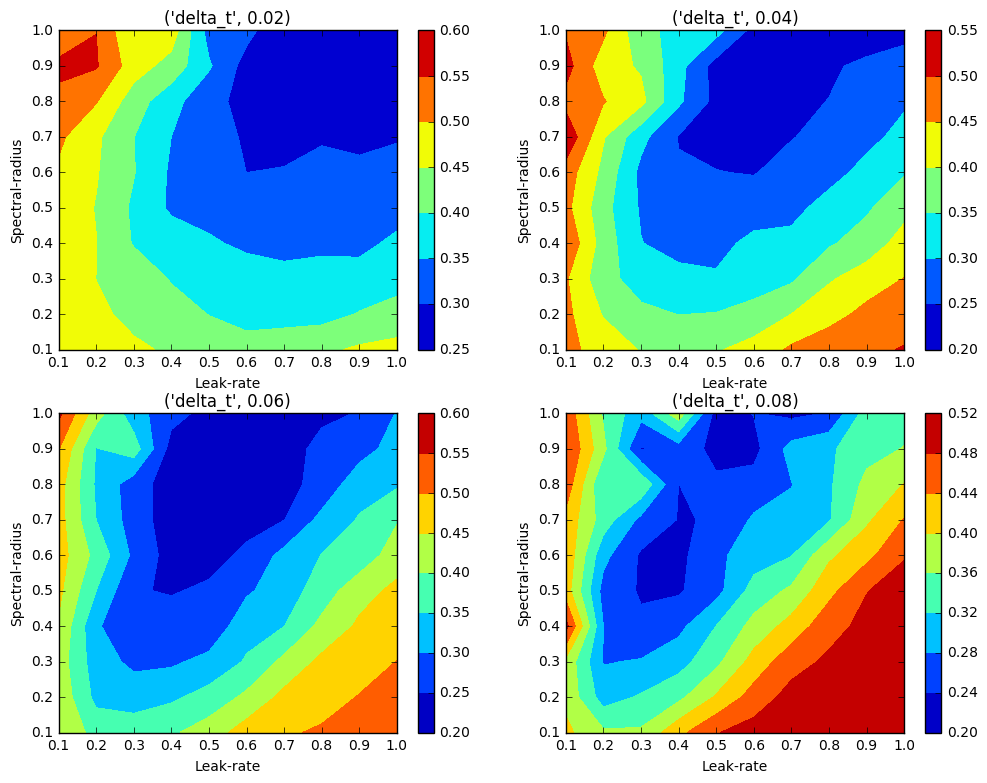

In [23]:
### Different delta_t

from matplotlib import pyplot
%matplotlib inline
print(delta_t)
xx, yy = np.meshgrid(l_rate, sp_rad)
pyplot.figure(figsize=(12,14))
for p in range(len(delta_t)):
    pyplot.subplot(3,2,p+1)
    pyplot.contourf(xx,
                    yy,delta_t_error[p][0].reshape(10,10).T)
    pyplot.title(("delta_t", delta_t[p]))
    pyplot.xlabel("Leak-rate")
    pyplot.ylabel("Spectral-radius")
    pyplot.colorbar()

### Different Neuronsizes

from matplotlib import pyplot
%matplotlib inline
print(n_neurons_slow)
xx, yy = np.meshgrid(l_rate, sp_rad)
pyplot.figure(figsize=(12,9))
for p in range(len(n_neurons_slow)):
    pyplot.subplot(2,2,p+1)
    pyplot.contourf(xx,
                    yy,neurons_slow_error[p].reshape(10,10).T)
    pyplot.title((n_neurons_slow[p],"Neurons"))
    pyplot.xlabel("Leak-rate")
    pyplot.ylabel("Spectral-radius")
    pyplot.colorbar()

In [25]:
#### Get Parameters from a good performing slowESN

nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=300,  # from 200 onwards test error decreases significantly
                          spectral_radius=0.8,  # high spectral rad is better (high fluctuations 0->1->0)
                          leak_rate= 0.6,   # adjust leak_rate
                          sparsity=0.95,     # 0.95
                          delta_t= 0.05,
                          noise=0.01,      # 0.001
                          input_shift=-0.5,    # 0
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_forcing=False,
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          random_state=rng,
                          silent=False)
train_bits, test_bits, train_parity, test_parity = produceTrainingData(42)
nParityESN.fit(train_bits, train_parity)

harvesting states...
fitting...
training error:
0.198427923283


array([[ 0.62660341],
       [ 0.70112616],
       [ 0.70552921],
       ..., 
       [ 1.01937465],
       [ 0.97527719],
       [ 1.03570496]])

In [26]:
##### Create Training Data for fastESN with output from slowESN
start_time = time.time()

new_rng = np.random.RandomState(1337)
new_N, new_n = 1500, 3
# new_bits, new_parity, new_target = Parity_Data_Generator.generateParityData(new_N, new_n, 
#                                                                             timescale=timescale,randomstate=new_rng)

# # Divide in training and test data
# traintest_cutoff = int(np.ceil(0.7 * len(bits)))
# new_train_bits, new_test_bits = new_bits[:traintest_cutoff], new_bits[traintest_cutoff:]
# # new_train_parity, new_test_parity = new_parity[:traintest_cutoff], new_parity[traintest_cutoff:]
# new_train_targets, new_test_targets = new_target[:traintest_cutoff], new_target[traintest_cutoff:]

# train_predicted_parity = nParityESN.predict(new_train_bits)
# test_predicted_parity = nParityESN.predict(new_test_bits)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---


In [27]:
#### FastESN ####
def runSomeFastConfigs(spectral_rad, leak_r, d_t, train_parity, test_parity, 
                       train_targets, test_targets, num_neurons=100):
    outputESN = ESN(n_inputs=1,
                              n_outputs=1,
                              n_reservoir=num_neurons,  
                              spectral_radius=spectral_rad,  # high spectral rad is better (high fluctuations 0->1->0)
                              leak_rate= leak_r,   # adjust leak_rate
                              delta_t= d_t,
                              sparsity=0.95,
                              noise=0.01,
                              input_shift=0,
                              input_scaling=3,  # 3 seems to be fine. Maybe use lower
                              teacher_forcing=False,
                              teacher_scaling=1.12,
                              teacher_shift=-0.4,
                              random_state=new_rng,
                              silent=False)
        # print(np.shape(bits),np.shape(parity),np.shape(target))
    outputESN.fit(train_parity, train_targets)
    pred_test = outputESN.predict(test_parity)
        
    print("Testing error")
    test_error = np.sqrt(np.mean((pred_test - test_targets) ** 2))
    print(test_error)
    return test_error

def produceFastTrainingData(randomState):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(randomState))

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
    train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    
    train_predicted_parity = nParityESN.predict(train_bits)
    test_predicted_parity = nParityESN.predict(test_bits)
    
    return train_predicted_parity, test_predicted_parity, train_targets, test_targets

In [28]:
new_trials = 1
n_neurons_fast = 50
# num_neurons_fast = [100]
delta_t_fast = np.linspace(0.05,0.3,num=6)
# l_rate_fast = np.linspace(0.4, 1, num=7)
l_rate_fast = np.linspace(0.1, 1, num=10)
# l_rate_fast = [0.6]
# sp_rad_fast = np.linspace(0.8, 1, num=3)
sp_rad_fast = np.linspace(0.1, 1, num=10)
# sp_rad_fast = [0.95]

run_time = time.time()
iterations, iterationcount = new_trials*len(sp_rad_fast)*len(l_rate_fast)*len(delta_t_fast), 0

delta_t_errors_fast = []
for dt_fast in delta_t_fast:
    all_errors_fast = [{} for _ in range(new_trials)]
    for i in range(new_trials):
        errors = []

        new_train_parity, new_test_parity, new_train_targets, new_test_targets = produceFastTrainingData(i)

        for l in l_rate_fast:
            for s in sp_rad_fast:
                print("Neurons:", n_neurons_fast, "Leak-rate:", l, "Spectral-radius:", s,"Delta_t:",dt_fast)
                errors.append(runSomeFastConfigs(s,l,dt_fast,new_train_parity, new_test_parity, new_train_targets, new_test_targets,n_neurons_fast))
                iterationcount = iterationcount + 1
                print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
        ## Save leak-rate,spectral-radius and error in dictionary
        all_errors_fast[i] = errors

    ### Average errors
    fast_errors_averaged_over_trials = np.zeros(100)
    for i in range(len(all_errors_fast)):
        e = all_errors_fast[i]
        fast_errors_averaged_over_trials = np.add(fast_errors_averaged_over_trials, np.array(e))

    fast_errors_averaged_over_trials = np.divide(fast_errors_averaged_over_trials, new_trials)
    
    delta_t_errors_fast.append(fast_errors_averaged_over_trials)
            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.1 Delta_t: 0.05
harvesting states...
fitting...
training error:
0.198970790196
Testing error
0.202612128543
--- Progress: 0.17% --- 0.27 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.2 Delta_t: 0.05
harvesting states...
fitting...
training error:
0.198601419932
Testing error
0.20294396342
--- Progress: 0.33% --- 0.35 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.3 Delta_t: 0.05
harvesting states...
fitting...
training error:
0.198514175094
Testing error
0.202577282527
--- Progress: 0.50% --- 0.43 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.4 Delta_t: 0.05
harvesting states...
fitting...
training error:
0.198439079565
Testing error
0.203157804755
--- Progress: 0.67% --- 0.51 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.5 Delta_t: 0.05
harvesting states...
fitting...
training error:
0.198190034409
Testing error
0.203435201037
--- Progress: 0.83% --- 0.59 minutes ---
Neurons: 50 Leak-rate: 0.1

In [29]:
import pickle
#### Save Data
# with open('dataFastDelta_tErrors.p','wb') as outputFile:
#     pickle.dump(delta_t_errors_fast,outputFile)
#     pickle.dump(fast_errors_averaged_over_trials, outputFile)
#     pickle.dump(n_neurons_fast, outputFile)
#     pickle.dump(delta_t_fast, outputFile)
#     pickle.dump(new_trials, outputFile)
#     pickle.dump(l_rate_fast, outputFile)
#     pickle.dump(sp_rad_fast, outputFile)
#### Load Data
with open('dataFastDelta_tErrors.p', 'rb') as inputFile:
    delta_t_errors_fast = pickle.load(inputFile)
    fast_errors_averaged_over_trials = pickle.load(inputFile)
    n_neurons_fast = pickle.load(inputFile)
    delta_t_fast = pickle.load(inputFile)
    new_trials = pickle.load(inputFile)
    l_rate_fast = pickle.load(inputFile)
    sp_rad_fast = pickle.load(inputFile)

data = [
     go.Contour(
        z=fast_errors_averaged_over_trials.reshape(10,10).T,
        x=l_rate_fast,
        y=sp_rad_fast,
        colorscale='Jet',
    )]
py.iplot(data)

[ 0.05  0.1   0.15  0.2   0.25  0.3 ]


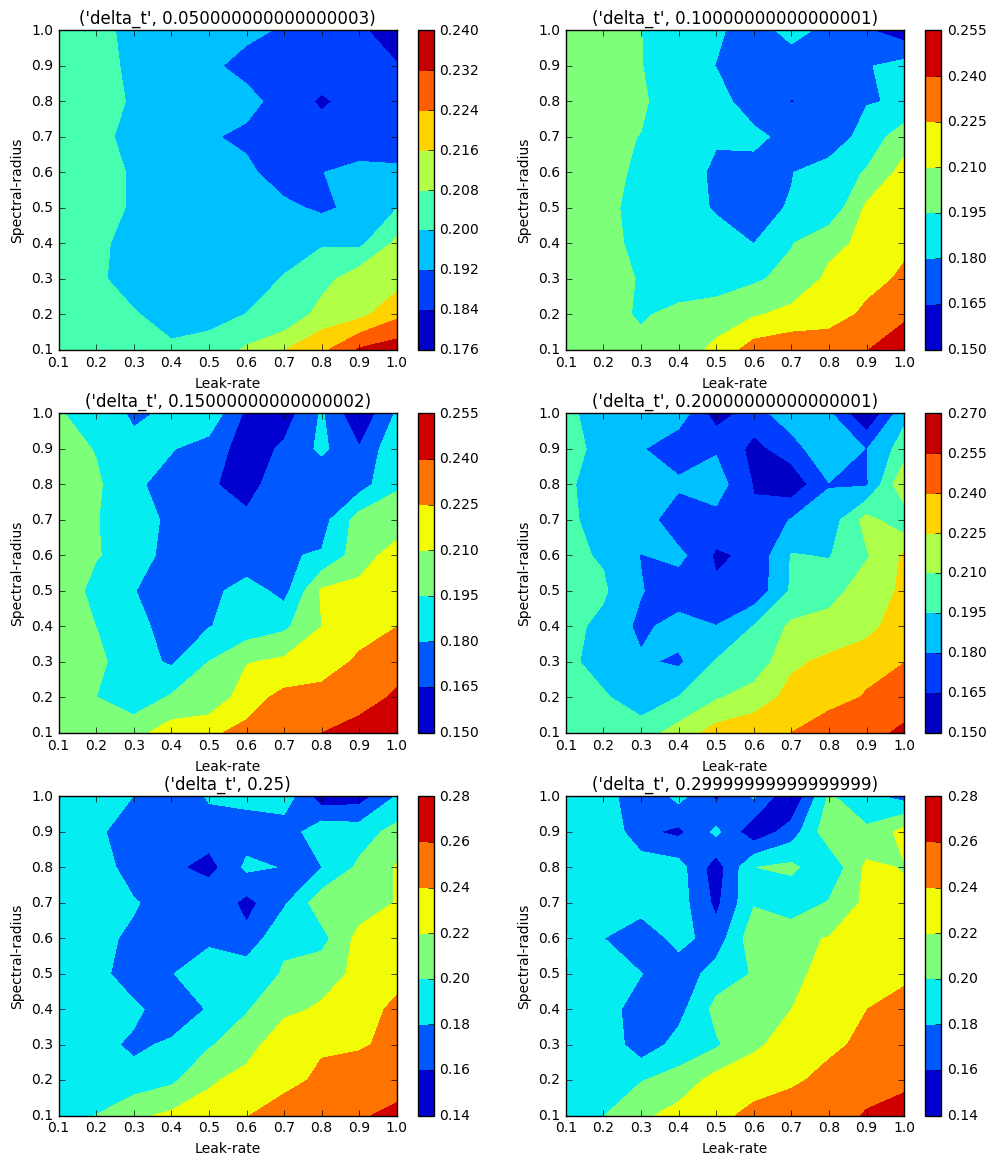

In [35]:
### Different delta_t

from matplotlib import pyplot
%matplotlib inline
print(delta_t_fast)
xx, yy = np.meshgrid(l_rate_fast, sp_rad_fast)
pyplot.figure(figsize=(12,14))
for p in range(len(delta_t_fast)):
    pyplot.subplot(3,2,p+1)
    pyplot.contourf(xx,
                    yy,delta_t_errors_fast[p].reshape(10,10).T)
    pyplot.title(("delta_t", delta_t_fast[p]))
    pyplot.xlabel("Leak-rate")
    pyplot.ylabel("Spectral-radius")
    pyplot.colorbar()

import plotly.plotly as py
import plotly.graph_objs as go

# c= ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(all_errors_fast))]
c= ["blue", "orange", "green", "cyan", "yellow", "magenta", "red", "black"]
data = []


x = np.repeat(l_rate_fast,len(l_rate_fast))
y = np.tile(sp_rad_fast,len(sp_rad_fast))
z = fast_errors_averaged_over_trials

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    name=("Fast network averaged over",new_trials,"Trials"),
    mode='markers',
    marker=dict(
        size=7,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)


data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     ),
#     go.zaxis=dict(
#         range=[0, 0.8]
#     ),
    scene=go.Scene(
        xaxis=go.XAxis(title='x = Leak-Rate'),
        yaxis=go.YAxis(title='y = Spectral Radius'),
        zaxis=go.ZAxis(title='z = Error')
        )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Fast Network Averaged')